In [ ]:
import os.path
from os import listdir, chdir
from os.path import isfile, join, getmtime, split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakfit_functions as pf
import xps_reference
from scipy.interpolate import make_interp_spline, splrep, BSpline
import scipy.signal
from tifffile import imsave
plt.rcParams["figure.dpi"] = 100

In [ ]:


'''
This program loops through all of the snapshots and will visualize the time series of the scans of each different
category of scans (o1s, ni2p, etc) based on the energy that they start with.  

The program also removes outliers by removing the three edge detectors and anything that is three standard deviations away
from the average value.

The function to plot the different groups of scans can be modified to show time instead of temperature, but this is approximate
as the snapshots are not taken at exact times or temperatures.  

This program will work for either a folder full of snapshots or a folder full of scans with the same number of data points.  
If the lengths of the scans are different, the master data table will break (could fix this later)
'''

#They types of scans are preset here
elements = {'Transition':['Ni2p3/2', 'Cr2p3/2', 'Mo3d', 'O1s', 'C1s'],
            'Minimum BE':[849, 570, 222,525,278],
            'Maximum BE':[866,582,242,538,290]
            }
element_transitions = pd.DataFrame(elements)

"""These functions are all utilities!"""
def EI_data_from_snapshot(linedata, kinetictobinding=True):
    """This block of code gets rid of the metadata starting with #, and sums up all of the individual measurements from
    each snapshot, and gets (energy, intensity) data in the numpy array 'dataset'"""

    str_dataset = []
    dataset = []  # this becomes your full dataset by the end, in python list format

    for row in linedata:
        if row.find('#') == -1:
            row_split = row.split()

            new_row = []
            row_str = ''  # accumulators
            intensity_sum = 0

            for element in row_split:
                try:
                    num_element = float(element)
                    if row_split.index(element) == 0:
                        if kinetictobinding:
                            new_row.append(1486.7-num_element)
                            row_str += element + '\t'
                        else:
                            new_row.append(num_element)
                            row_str += element + '\t'
                    else:
                        intensity_sum += num_element
                except:
                    pass
            row_str += str(intensity_sum) + '\n'
            str_dataset.append(row_str)
            new_row.append(intensity_sum)
            dataset.append(new_row)

    data = np.array(dataset)  # converts the data to a numpy array
    return data

def remove_outliers(edgesize, sigma, data):
    """Removes outliers by excluding the edge channels (defined by edgesize) and excluding anything with a value or
    derivative that is sigma standard deviations away from the mean"""
    diffdata = np.gradient(data[:, 1])
    averagediff = np.average(diffdata)
    stddiff = np.std(diffdata)
    outlierlist = []
    averagintensity = np.average(data[:, 1])
    stdintensity = np.std(data[:, 1])

    for i in range(len(diffdata)):
        if (abs(diffdata[i] - averagediff) > sigma * stddiff):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        elif (abs(data[i, 1] - averagintensity) > sigma * stdintensity):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        if ((i <= (edgesize-1)) and len(diffdata) >= edgesize):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        elif ((len(diffdata) - i) <= edgesize):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
    return data

def find_ni_peak(x, y, guess=[100, 853, 2, 100, 853, 2]):
    """finds the center of the nickel peak using 1 voigt peak centered around 853"""
    # guess = [ampG1, cenG1, sigmaG1,ampL1, cenL1, widL1]
    paramopt = pf.fit_1Voigt(x, y, guess)

    return paramopt

def gather_snapshots(transition, masterdata,normalize=False):
    """
    Given a transition name (string) and a dataframe containing arrays of data corresponding to a transition, return
    a triangular set of coordinates with format (
    :param transition:
    :param masterdata:
    :return: plotdata
    """
    sorted_data = masterdata[masterdata.scantype == transition]
    plotdata = np.zeros((0,3))
    for j, i in enumerate(sorted_data.data):
        snapshot = (np.array(i))

        if normalize:
            snapshot = xps_reference.normalize_to_one(snapshot)
        indexs = np.zeros((snapshot.shape[0],1))
        indexs[:] = j
        snapshot = np.hstack((indexs,snapshot))
        plotdata = np.vstack((plotdata,snapshot))

    return plotdata

def normalize_group(masterlist):
    """Takes the master list and normalizes the spectra in the master list"""

    for i, name in enumerate(masterlist.index):
        rollingsum = 0
        snapshot = masterlist.iloc[i]
        if snapshot.scantype == "Ni2p3/2":
            j = i+1
            rollingsum +=snapshot.scansum
            scanlist = []
            scanlist = scanlist.append(snapshot.scantype)
            while ("Ni2p3/2" not in scanlist) and ("Mo3d" not in scanlist) and ("Cr2p3/2" not in scanlist):
                current = masterlist.iloc[j]
                if "O1s" in current.scantype:
                    j += 1
                    continue
                elif current.scantype in scanlist:
                    j +=1
                    continue
                rollingsum += current.scansum
                j+=1

            #print(rollingsum)
            rollingsum=0

    return masterlist



"""This is the start of the main function!!!"""


def snapshots_from_dir(search_dir):
    """This function gathers the snapshots from each file and aligns them based off of the nickel peak"""
    # sort the snapshot files by the snapshot number- sorting by date doesn't work because they were all created by the exporter around the same time
    files = [f for f in listdir(search_dir) if isfile(join(search_dir, f))]
    files.sort(key=lambda x: x.split('-')[5])
    files.sort(key=lambda x: len(x))
    files = [os.path.join(search_dir, f) for f in files] # add path to each file

    masterlist = pd.DataFrame(columns=['filename','data','scantype', 'date','time','scansum'])
    shift = 0
    signalsum = 0
    for i, name in enumerate(files):
        #This loop gathers all the data and aligns the spectra
        if not (".txt" in name):
            continue
        elif ('._' in name):
            continue
        filepath = os.path.join(search_dir, name)
        f = open(filepath)
        lines = f.readlines()
        f.close()

        line1 = lines[0].split(" ")     #get the xps transition type from the metadata
        transition = line1[-2]+ line1[-1]
        transition = transition.replace("\n","")
        pair = os.path.split(name)
        tail = pair[1]
        filedate = tail.split('-')[0]
        filetime = tail.split('-')[1]
        filetime = filetime.split('_')[0]
        data = EI_data_from_snapshot(lines)

        #optional outlier removal
        #data = remove_outliers(3, 3)

        center = 0
        # #defines an alignment transition, in this case nickel, and aligns all snapshots that are not Ni by the Ni shift
        # #shift is updated on every Ni peak
        # if "Ni2p3/2" in transition:
        #     #If the snapshot is a nickel snapshot, fit the nickel peak with a voigt peak.  if you can successfully fit,
        #     #update the peak shift parameter
        #     try:
        #         fitparams = find_ni_peak(data[:, 0], data[:, 1])
        #         center = fitparams[1]
        #         shift = 852.6 - center
        #     except RuntimeError:
        #         print("peak finding failed: " + tail)
        #         centerindex = np.argmax(data[:,1])
        #         center = data[centerindex,0]
        #         print("using simple max at: " + str(center))
        #         shift = 852.6 - center
        #         #make the shift- this function remembers the last alignment feature


        """Do the shift based on the valence band intersection with zero"""
        if "Valence" in transition:
            derivatives = np.gradient(data[:,1])

            #smooth the derivative using a b spline
            flipped_derivatives = np.flip(derivatives)
            flipped_x = np.flip(data[:, 0])
            spline_derivative = splrep(flipped_x, flipped_derivatives, s=10000)
            smoothed_derivative = BSpline(*spline_derivative)(flipped_x)
            valence_edge = (flipped_x[np.argmin(smoothed_derivative)])

            # plt.plot(np.flip(data[:, 0]), BSpline(*spline_derivative)(flipped_x))
            # plt.plot(data[:,0], derivatives)
            # plt.show()
            # #Optionally just use the minimum of the derivative
            # valence_edge = (data[np.argmin(derivatives),0])
            # print(valence_edge)
            shift = 0-valence_edge


        data = xps_reference.shift_spectra(data, shift)
        masterlist = masterlist.append([{'filename': name,
                                         'data': data,
                                         'scantype': transition,
                                         'date': filedate,
                                         'time': filetime,
                                         'center': center,
                                         'scansum': np.sum(data[:,1])
                                         }])

    masterlist = masterlist.reset_index(drop=True)


    return masterlist

# directories = ['/Volumes/DATA STICK/Muri ni22cr6mo fast hold 4-11-22/Snapshots/snapshots 4-11-22',
#                '/Volumes/DATA STICK/Muri ni22cr6mo fast hold 4-11-22/4-13-22 exports/4-13-22 snapshots',
#                '/Volumes/DATA STICK/Muri ni22cr6mo fast hold 4-11-22/4-18-22 exports/4-18-22 snapshots']
# masterlist = snapshots_from_dir(directories[0])
# masterlist = masterlist.append(snapshots_from_dir(directories[1]),ignore_index=True)
# masterlist = masterlist.append(snapshots_from_dir(directories[2]),ignore_index=True)
# masterlist = masterlist.reset_index(drop=True)





In [12]:
#directory = '/Users/apple/Sync/Research/Native Oxide work/Ni22Cr6Mo ambient oxide 9-21-23/-27 deg'
directory = '/Users/apple/Sync/Research/Muri NiCr experiments/Muri ni22cr6mo fast hold 4-11-22/Snapshots/snapshots 4-11-22'
#directory = '/Volumes/DATA STICK/Native NiCr Oxides/NiCrW live heating 3-7-23/150-500 Live Ramp'
#directory = "/Volumes/DATA STICK/Native NiCr Oxides/Ni15Cr Live Heating"
masterlist = snapshots_from_dir(directory)


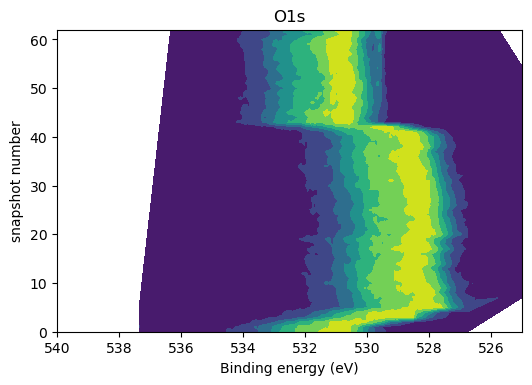

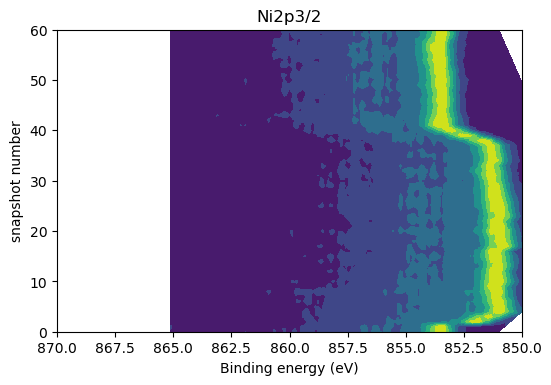

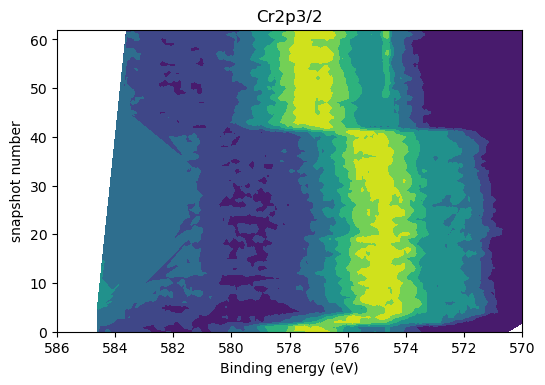

ValueError: x and y arrays must have a length of at least 3

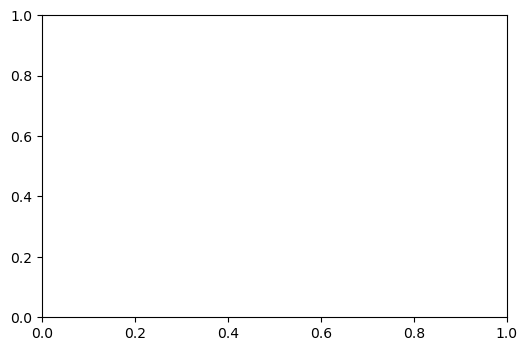

In [13]:
oxygen = gather_snapshots("O1s",masterlist,True)
fig1 = plt.figure(1)
ax = fig1.add_subplot()
ax.tricontourf(oxygen[:,1],oxygen[:,0],oxygen[:,2],cmap='viridis')
ax.set_xlabel('Binding energy (eV)')
ax.set_ylabel('snapshot number')
plt.title("O1s")
plt.xlim([np.amax(oxygen[:,1]), np.amin(oxygen[:,1])])
plt.xlim([540,525])
plt.show()

nickel = gather_snapshots("Ni2p3/2",masterlist,True)
fig2 = plt.figure(2)
ax = fig2.add_subplot()
ax.tricontourf(nickel[:,1],nickel[:,0],nickel[:,2],cmap='viridis')
ax.set_xlabel('Binding energy (eV)')
ax.set_ylabel('snapshot number')
plt.title("Ni2p3/2")
plt.xlim([np.amax(nickel[:,1]), np.amin(nickel[:,1])])
plt.xlim([870,850])
plt.show()


chromium = gather_snapshots("Cr2p3/2",masterlist,True)
fig3 = plt.figure(3)
ax = fig3.add_subplot()
ax.tricontourf(chromium[:,1],chromium[:,0],chromium[:,2],cmap='viridis')
ax.set_xlabel('Binding energy (eV)')
ax.set_ylabel('snapshot number')
plt.title("Cr2p3/2")
plt.xlim([np.amax(chromium[:,1]), np.amin(chromium[:,1])])
plt.xlim([586,570])
plt.show()


# molybdenum = gather_snapshots("Mo3d",masterlist, True)
# fig4 = plt.figure(4)
# ax = fig4.add_subplot()
# ax.tricontourf(molybdenum[:,1],molybdenum[:,0],molybdenum[:,2])
# ax.set_xlabel('Binding energy (eV)')
# ax.set_ylabel('snapshot number')
# plt.title("Mo3d")
# plt.xlim([np.amax(molybdenum[:,1]), np.amin(molybdenum[:,1])])
# plt.xlim([237, 225])


valence = gather_snapshots("Valence",masterlist,True)
fig5 = plt.figure(5)
ax = fig5.add_subplot()
ax.tricontourf(valence[:,1],valence[:,0],valence[:,2],cmap='viridis')
ax.set_xlabel('Binding energy (eV)')
ax.set_ylabel('snapshot number')
plt.title("Valence")
plt.xlim([np.amax(valence[:,1]), np.amin(valence[:,1])])
plt.xlim([12,-4])
plt.show()

# moly = masterlist[masterlist.scantype =='Mo3d']
ni = masterlist[masterlist.scantype == "Ni2p3/2"]
'''print(moly.index[104])
file1 = (moly.iloc[104])
print(file1.filename)
print(ni.index[102])
file2 = (ni.iloc[102])
print(file2.filename)'''





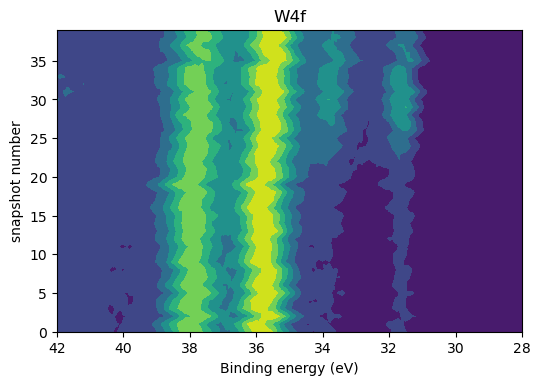

In [ ]:
tungsten = gather_snapshots("W4f",masterlist,True)
fig4 = plt.figure(4)
ax = fig4.add_subplot()
ax.tricontourf(tungsten[:,1],tungsten[:,0],tungsten[:,2],cmap='viridis')
ax.set_xlabel('Binding energy (eV)')
ax.set_ylabel('snapshot number')
plt.title("W4f")
plt.xlim([np.amax(tungsten[:,1]), np.amin(tungsten[:,1])])
plt.xlim([42,28])
plt.show()
